In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import sklearn
import torch
import os
import re
from os import listdir
from os.path import isfile, join
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt 
import shap
from sklearn.metrics import accuracy_score
nltk.download("stopwords", quiet=True)
import sys; sys.path.insert(0, '../src/')
import necsuf_tabular_text as nec_suf
import cum_shp_plot
import model_weakness_spam

In [2]:
df = pd.read_csv("../datasets/spam_clean_str.csv")
df.drop(["Unnamed: 0"], axis=1, inplace=True)

## Intialization: data loading

In [3]:
df_for_classification = pd.read_csv("../datasets/spam_for_classification.csv")
df_for_classification.drop(["Unnamed: 0"], axis=1, inplace=True)
for c in df_for_classification.columns:
    df_for_classification[c] = df_for_classification[c].apply(lambda x: np.array(eval(x)) if not isinstance(x, int) else x)

### Train NN on top of spam dataset

In [4]:
df_for_classification_flat = pd.read_csv("../datasets/spam_for_classification_flat.csv")
df_for_classification_flat.drop(["Unnamed: 0"], axis=1, inplace=True)

In [5]:
X_vectors,y_vectors = np.array(df_for_classification_flat.iloc[:, :-1]), np.array(df_for_classification_flat.iloc[:, -1])

X_train_vectors, X_test_vectors, y_train_vectors, y_test_vectors = \
    sklearn.model_selection.train_test_split(X_vectors, y_vectors, test_size=.2, random_state=42)

In [6]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train_vectors, y_train_vectors)
clf.score(X_test_vectors, y_test_vectors)

0.9831081081081081

In [7]:
preds = df_for_classification_flat.apply(lambda x: clf.predict(x.iloc[:-1].values.reshape(1, -1))[0], axis=1)
df_for_classification_flat['Model_pred'] = preds
df_for_classification['Model_pred'] = preds

### choose inp

In [8]:
## 998 is just a random example instance
inp_raw = pd.DataFrame(df.iloc[998]).T
inp_raw

,From,To,Subject,save_urls,save_emailsadd,first_sent,second_sent,penult_sent,last_sent,outcome
998,barrister johnson akerele adewale1 mail com,cypherpunks einstein ssz com cypherpunks ein...,request assistance,http thinkgeek com sf https lists sourceforge ...,spamassassin sightings lists sourceforge net,barrister adewale coker chambers,legal practitioners notary public,welcome geek heaven,spamassassin sightings mailing list,1


In [9]:
inp_vectors = pd.DataFrame(df_for_classification.iloc[998]).T
num_features = len(inp_vectors.columns[:-2])

In [10]:
inp_final_rep = pd.DataFrame(df_for_classification_flat.iloc[998]).T

In [11]:
f_inp = clf.predict(inp_final_rep.iloc[:, :-2])
f_inp

array([1])

### Ref choice

The non-categorical nature of these features necessitates a little more careful translation from user query to selection criteria from dataset

In [12]:
# this is an example of how to use more involved selection criteria, but we do not pursue it below
relevant_1 = df_for_classification[df_for_classification.outcome != inp_vectors.outcome.item()]

chosen_ind = nec_suf.close_or_distant_neighbours(relevant_1, inp_vectors, 'From_glv_vec', like=True, perc=0.1);

### Example: identifying minimal sufficient factors + necessity scores for all references of opposite outcome from inp

In [13]:
CF_condition_1 = df_for_classification.outcome != inp_vectors.outcome.item()
# CF_condition_1_raw = df_just_str.outcome != inp_raw_just_str.outcome.item()
CF_r2i, CF_i2r, \
CF_i2r_raw_text, refs = nec_suf.suff_nec_pipeline(CF_condition_1, inp_vectors, 
                                        clf, df_for_classification, num_features,
                                        datatype='Text', inp_raw=inp_raw, dataset_raw=df, predict=True)

In [14]:
print("##################")
print("Sufficiency R2I")
print("##################")
CF_df_deg_r2i = nec_suf.deg_nec_suff(CF_r2i, inp_raw, f_inp, clf, num_features, r2i=True, pred_on_fly=False, deg_thresh=0)

sub_df_filtered_r2i = nec_suf.filter_by_degree_and_overalp(CF_df_deg_r2i, degree_thresh=0.65, subset_max_num=10)
print("------------------")
print("necessity score: ", nec_suf.recall_nec_score(CF_r2i, sub_df_filtered_r2i, f_inp))
print("------------------")
sub_df_filtered_r2i

##################
Sufficiency R2I
##################
------------------
necessity score:  0.42052961924288484
------------------


,subset,degree,string,cardinality,cost
135,"[0, 1, 2, 8]",0.665882,From barrister johnson akerele adewale1 ma...,4,11.655064
188,"[1, 2, 3, 6]",0.705882,To cypherpunks einstein ssz com cypherpun...,4,12.339939
133,"[0, 1, 2, 6]",0.683529,From barrister johnson akerele adewale1 ...,4,12.585011
288,"[0, 1, 5, 6, 8]",0.690196,From barrister johnson akerele adewale1 ...,5,12.923916
199,"[1, 2, 6, 8]",0.917647,To cypherpunks einstein ssz com cypherpun...,4,13.624824
411,"[0, 1, 3, 6, 7, 8]",0.669804,From barrister johnson akerele adewale1 ...,6,13.667344
197,"[1, 2, 5, 8]",0.703137,To cypherpunks einstein ssz com cypherpunk...,4,13.767126
198,"[1, 2, 6, 7]",0.694118,To cypherpunks einstein ssz com cypherpun...,4,14.085028
406,"[0, 1, 3, 4, 6, 8]",0.691765,From barrister johnson akerele adewale1 ...,6,14.492979
335,"[1, 2, 3, 7, 8]",0.745490,To cypherpunks einstein ssz com cypherpun...,5,14.555687


In [15]:
print("##################")
print("Sufficiency I2R")
print("##################")
CF_df_deg_i2r = nec_suf.deg_nec_suff(CF_i2r, inp_raw, f_inp, clf, num_features,
                                     r2i=False, CF_i2r_raw_text=CF_i2r_raw_text, pred_on_fly=False, deg_thresh=0)
sub_df_filtered_i2r = nec_suf.filter_by_degree_and_overalp(CF_df_deg_i2r, degree_thresh=0.9, subset_max_num=10)
print("------------------")
print("necessity score: ", nec_suf.recall_nec_score(CF_i2r, sub_df_filtered_i2r, f_inp, r2i=False))
print("------------------")
sub_df_filtered_i2r

##################
Sufficiency I2R
##################
------------------
necessity score:  0.3490037719549374
------------------


,subset,degree,string,cardinality,cost
215,"[1, 4, 6, 8]",0.903922,To yyyy localhost netnoteinc com spamassa...,4,6.458990
190,"[1, 2, 3, 8]",0.927059,To yyyy localhost example com craig hughes ...,4,7.009566
77,"[1, 2, 6]",0.916863,To zzzz localhost netnoteinc com fork exa...,3,7.976747
194,"[1, 2, 4, 8]",0.930588,To yyyy localhost netnoteinc com theo van...,4,8.483268
409,"[0, 1, 3, 5, 6, 8]",0.907843,From daniel rogers rogersd nanaimo islan...,6,9.060826
267,"[0, 1, 2, 5, 8]",0.927843,From daniel rogers rogersd nanaimo island...,5,10.797772
382,"[0, 1, 2, 3, 4, 5]",0.921961,From daniel rogers rogersd nanaimo islan...,6,11.965981
491,"[0, 2, 3, 5, 6, 7, 8]",0.917647,From daniel rogers rogersd nanaimo islan...,7,12.634626
428,"[0, 2, 4, 5, 6, 8]",0.907059,From daniel rogers rogersd nanaimo islan...,6,14.119186


### SHAP comparison

In [16]:
CF_condition_string = "dataset.outcome != inp_i.outcome.item()"
all_inp_deg_r2i, all_inp_deg_i2r, all_shaps = \
    cum_shp_plot.cumul_shap_vs_us_multi_input(df_for_classification, clf, CF_condition_string, 
                                    num_features, num_inp=25, datatype='Text', 
                                    df_flattened=df_for_classification_flat)

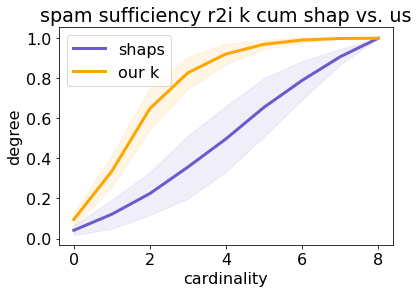

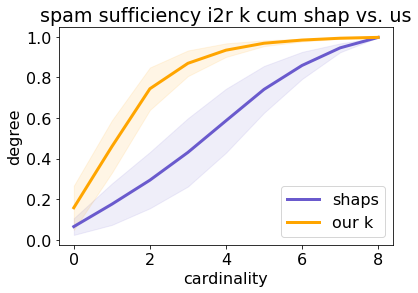

In [17]:
cum_shp_plot.mean_and_plot(all_inp_deg_r2i, all_shaps, title_name='sufficiency r2i', dataset_name='spam')
cum_shp_plot.mean_and_plot(all_inp_deg_i2r, all_shaps, title_name='sufficiency i2r', dataset_name='spam')

### Adverserial Example

In [18]:
# sample some spam examples, and see what minimal changes to those spam emails would have resulted in non-spam predictions
ref_inds = df[df['outcome']==1].sample(n=7, random_state=42).index
refs = df_for_classification.loc[ref_inds]
refs_present = df.loc[ref_inds]
refs_present

,From,To,Subject,save_urls,save_emailsadd,first_sent,second_sent,penult_sent,last_sent,outcome
1249,jourdain kir 31 yahoo com,yyyy njcc com yyyy net1plus com yyyy new...,hi joseph personal information wanted p,NaN,name domain com please,request,free loan evaluation,allow hours email address remo,ved,1
1054,resumevalet info resumevalet com,yyyy cv spamassassin taint org,adv put resume back work,http www resumevalet com http www resumevalet com,NaN,dear candidate,recently came across posting resume internet,copyright,professionals online network inc,1
1744,issac abner earthlink net,yyyy localhost netnoteinc com recipient net...,telecom consolidation begins accelerate owwra,NaN,NaN,igtt,vol,NaN,ikxrkobewgotpevemtbokjgssytdinm,1
1749,jacqui devito goodroughy ananzi co za,picone linux midrange com,enlargement breakthrough ...,NaN,NaN,recent survey conducted,durex,olutionary pill developed world famous pharmac...,ncrease size enter detailsto come open,1
1461,sue gort44 excite com,yyyy localhost netnoteinc com ameritex netway,build great future,http www page4life org users 69chevelle http ...,NaN,easy return,learn receive monthly check,opt,please go opt website,1
1727,rose xu email com,yyyyac idt net,adv harvest lots target email address quickly,http www wldinfo com download email ese zip ht...,NaN,want,harvest lot target email,line adv provide notification commercial,advertisement persons 18yrs old,1
596,garry gstechs fastmail fm,yyyy localhost netnoteinc com fork spamassas...,greetings calif,http xent com mailman listinfo fork,NaN,want make million bucks year,probably going happen,personally speak within hours,removed mailing list please type remove subjec...,1


In [19]:
model_weakness_spam.model_gaming(clf, refs, df_for_classification, num_features, num_inp=20, df_flattened=df_for_classification_flat, df_raw=df)

----------------------
gaming option no.:  0
----------------------


,From,To
3528,crispin cowan crispin wirex com,yyyy localhost example com mailing list secprog securityfocus com moderator secprog securityfocus com scottm crystal ncc cc nm us


----------------------
gaming option no.:  1
----------------------


,From,first_sent
3528,crispin cowan crispin wirex com,scott mackenzie wrote


----------------------
gaming option no.:  2
----------------------


,From,first_sent
3067,tim one comcast net tim peters,tim


----------------------
gaming option no.:  3
----------------------


,From,To
2248,eugen leitl eugen leitl org,yyyy localhost example com fork example com tom tomwhore slack net pine bso 4 44 0209181012190 26668 100000 crank slack net fork admin xent com


----------------------
gaming option no.:  4
----------------------


,From,To
1978,matthias saou matthias rpmforge net,yyyy localhost example com rpm zzzlist freshrpms net 3d89aa17 4090005 leenx co za rpm zzzlist admin freshrpms net rpm zzzlist freshrpms net
